# Dataset

In [1]:
import torch
import numpy as np
from torch.utils.data.dataset import Dataset
from pathlib import Path
from PIL import Image

class BIPEDv2(Dataset):
    def __init__(self, ori_path, gt_path):
        self.ori_path = Path(ori_path)
        self.gt_path = Path(gt_path)
        self.indexes = list(set([x.stem for x in self.ori_path.iterdir() if not x.name.startswith(".")]) & set([x.stem for x in self.gt_path.iterdir() if not x.name.startswith(".")]))
    
    def __len__(self):
        return len(self.indexes)
    
    def __getitem__(self, i):
        x = np.array(Image.open(self.ori_path.joinpath(self.indexes[i]).with_suffix(".jpg")))
        denom = 255 if x.max() > 1 else 1
        y = np.array(Image.open(self.gt_path.joinpath(self.indexes[i]).with_suffix(".png")))
        
        return torch.Tensor(x / denom).permute(2, 0, 1), torch.Tensor(y / denom)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epoch = 20
batch_size = 4
learning_rate = 1e-4
biped_dataset = BIPEDv2(
    "BIPEDv2/BIPED/edges/imgs/train/rgbr/real",
    "BIPEDv2/BIPED/edges/edge_maps/train/rgbr/real"
)
print(device)

cuda


# Train

In [3]:
from model import DexiNed
from losses import bdcn_loss2
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader

model = DexiNed()
# criterion = nn.CrossEntropyLoss()
criterion = bdcn_loss2
l_weight = [0.7,0.7,1.1,1.1,0.3,0.3,1.3] # New BDCN  loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loader = DataLoader(biped_dataset, batch_size=4)

logging = {
    'train_loss': []
}

In [4]:
# launch = False
launch = True

In [5]:
if not launch:
    print("Please set launch to True")
else:
    model.train()
    model = model.to(device)
    for e in range(epoch):
        epoche_loss = []
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            # output = model(x)[-1].squeeze()
            # loss = criterion(output, y)
            outputs = [layer.squeeze() for layer in model(x)]
            loss = sum([criterion(preds, y, l_w) for preds, l_w in zip(outputs,l_weight)])
            loss.backward()
            optimizer.step()
            print("*", end="") # , flush=True)
            epoche_loss.append(loss.detach().item())
        
        logging['train_loss'].append(np.mean(epoche_loss))
        print(f"\nIn epoch {e}, the average loss is {logging['train_loss'][-1]}")

    # save files
    model = model.to('cpu')

**************************************************
In epoch 0, the average loss is 0.9965736973285675
**************************************************
In epoch 1, the average loss is 0.9744052386283875
**************************************************
In epoch 2, the average loss is 0.9623892664909363
**************************************************
In epoch 3, the average loss is 0.9521347403526306
**************************************************
In epoch 4, the average loss is 0.9432904124259949
**************************************************
In epoch 5, the average loss is 0.9339976793527603
**************************************************
In epoch 6, the average loss is 0.899992573261261
**************************************************
In epoch 7, the average loss is 0.8693372857570648
**************************************************
In epoch 8, the average loss is 0.8542537844181061
**************************************************
In epoch 9, the average loss is 

# Result

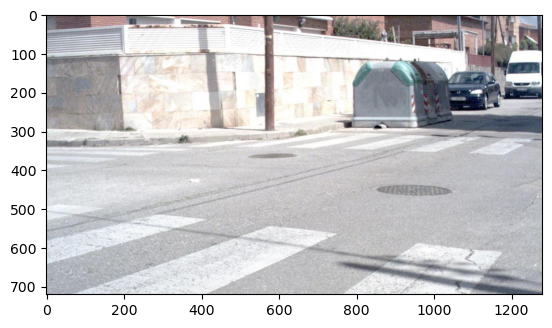

In [ ]:
import matplotlib.pyplot as plt

# load test data
test_dataset = BIPEDv2(
    "./BIPEDv2/BIPED/edges/imgs/test/rgbr",
    "./BIPEDv2/BIPED/edges/edge_maps/test/rgbr"
)
# take one example
x, y = test_dataset[4]
plt.imshow(x.permute(1,2,0))
plt.show()

In [ ]:
# inference
model.eval()
with torch.no_grad():
    model.to(device)
    yhat = model(x.unsqueeze(0).to(device))[-1].squeeze()
    yhat = yhat.to('cpu')
    model.to('cpu')
yhat = torch.where(yhat<0, 0, yhat)
yhat = torch.where(yhat>1, 1, yhat)

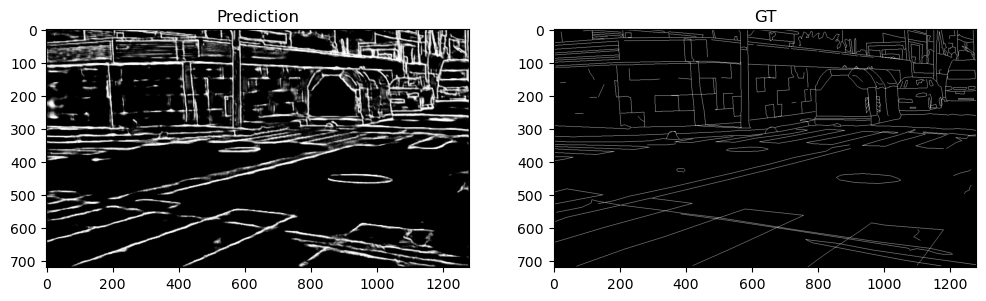

In [8]:
# display result
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
# fig.suptitle(img_index)
ax1.imshow(yhat, cmap="gray")
ax1.set_title("Prediction")
ax2.imshow(y, cmap="gray")
ax2.set_title("GT")
plt.show()